# Estimating tidal feature characterisitcs with CNN

## Motivation

The training data is from Subaru HSC. Images were extracted from a catalogue of visually classified tidal features of galaxies in a 200 deg2 section of the first public data release made by Erin Kado-Fong. This catalog can be found in the `Catalogues` directory. Each of the 21,000 targets is classified as either `Stream`, `Shell`, or `Non-detection`. The detections were boosted by an algorithm which highlights features with high spatial frequencies. In this project, I will use this catalogue as a training set for convolutional neural networks, `CNN`, which can then be used on the full survey.

## Getting started

### Dowloading the images

Downloading of the images is described on my `github` page: https://github.com/cbottrell/SubaruHSC_TidalCNN

The images are already normalized with a zeropoint of $m_{\mathrm{AB,zp}} = 27$ magnitudes. Because the WCS coordinate matrix is not the same for every patch of sky and the query tool only accepts image sizes in angular units (arcsec, for example), the number of pixels along each dimension of the images is not exact. Consequently, I downloaded images with a fixed angular size of $88.2$ arcsec. With the HSC CCD scale of $\sim0.168$ arcsec/pixel, this produces images with sizes roughly $525\times525$ which can then be cropped down to the desired $512\times512$ size.

### Estimating target sizes
Some sources do not have estimates of their sizes in the HSC data archive server. For these (or any) targets, I obtain the sizes using Sextractor (Bertin & Arnouts 1996) -- specifically, the version recently ported as the Python module, `sep` (Barbary 2016).

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os,sys
from glob import glob
from astropy.io import fits
from astropy.wcs import WCS
import sep


def Generate_Segmap(filename,galaxy_coordinates_wcs):
    '''
    Return a segmentation map where: (1) only the target galaxy is 
    included in the map and everything else is background; and (2)
    every object has a unique flag and the target is at the center
    of the colormap. Next returns are (3) the flagID of the 
    primary galaxy, (4) median background estimate (sky only),
    (5) rms estimate of background (sky pixels), (6) a catalog of
    all object properties.
    '''
    # Primary HDU for file
    hdulist = fits.open(filename)
    # obtain wcs info
    w = WCS(hdulist[1].header, hdulist)
    # image data
    image = hdulist[1].data.astype(float)
    # close Primary HDU
    hdulist.close()
    # filter kernel
    filter_kernel = np.loadtxt('/home/bottrell/utils/sdss-cfg/gauss_3.0_7x7.conv',skiprows=2)
    # use std of full image as detection threshold
    guess_rms = np.std(image)
    # mask all sources above std for background statistics
    mask = (image>guess_rms)
    # bkg object which includes sky() and rms() methods
    bkg = sep.Background(image, mask=mask, bw=32, bh=32, fw=3, fh=3)
    # run sep.extract() on image
    objCat,sexseg = sep.extract(image, thresh=1.0, err=bkg.rms(), mask=None, minarea=5,
                             filter_kernel=filter_kernel,filter_type='conv',deblend_nthresh=32,
                             deblend_cont=0.001, clean=True,clean_param=1.0, segmentation_map=True)
    # median background
    bkg_med = np.median(image[sexseg==0])
    # background noise
    bkg_rms = np.std(image[sexseg==0])
    # determine galaxy position in pixels (origin 0 for python indexing)
    galaxy_coordinates_pixels = tuple(w.wcs_world2pix([galaxy_coordinates_wcs],0).astype(int)[0][::-1])
    # identify flag for target galaxy in segmentation map
    pflag = sexseg[galaxy_coordinates_pixels]
    # galaxy segmentation map (only these pixels are used in the model)
    galseg = sexseg==pflag
    return galseg,sexseg,pflag,bkg_med,bkg_rms,objCat

catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')[6254:6255,:]

objIDs = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)

# filterIDs = ['g','r','i','z','y']
filterIDs = ['g',]

for objID,ra,dec in zip(objIDs,ras,decs):
    for filterID in filterIDs:
        # filename
        fileName = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/{}_Cutout-525x525_{}.fits'.format(objID,filterID)
        print(fileName)
        # continue if image does not exist
        if not os.access(fileName,0):continue
        
        galaxy_coordinates_wcs = (ra,dec)
        galseg,sexseg,pflag,bkg_med,bkg_rms,objCat = Generate_Segmap(fileName,galaxy_coordinates_wcs)
        
        area_pixels = objCat[pflag-1][1]
        req = int(np.ceil(np.sqrt(float(area_pixels/np.pi))))
        print(req*0.168)


/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237665355622908267_Cutout-525x525_g.fits
46.032000000000004


### Plot `sep` example

Here I plot the image and segmentation map for last galaxy processed above to show that the masking is behaving properly. The dark blue at the center corresponds to pixels that have been allocated to the target galaxy.

/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


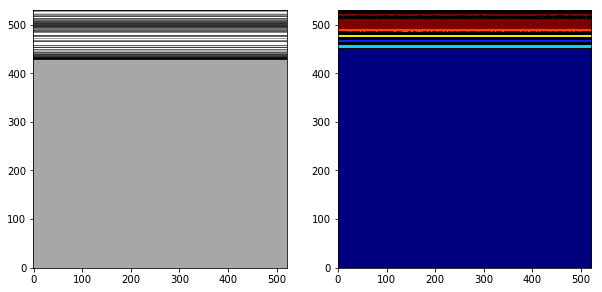

In [7]:
fig,axarr = plt.subplots(1,2,figsize=(10,5))
iData = np.log10(fits.getdata(fileName,0))
axarr[0].imshow(iData,vmin=-3,vmax=np.nanmax(iData[sexseg==pflag]),cmap='Greys',origin='lower')
cmap = cm.jet
cmap.set_bad('black',1.)
# total number of unique flags
rflags = np.unique(sexseg).astype(int)
# reorder from 0 to N (only strictly necessary if this is a cutout of a larger map)
nflags = np.arange(rflags.shape[0])
# reorder values so that pflag is in the middle of the color spectrum
a,b = rflags==pflag,int(np.floor(rflags.shape[0]/2))
rflags[a],rflags[b] = rflags[b],rflags[a]
segmap = np.zeros(sexseg.shape)
for rflag,nflag in zip(rflags,nflags):
    if rflag!=0:
        segmap[sexseg==rflag]=nflag
    else:
        segmap[sexseg==rflag]=np.nan
segmap[galseg] = 0
axarr[1].imshow(segmap,cmap=cmap,origin='lower',vmin = np.nanmin(segmap),vmax = np.nanmax(segmap))
        

### Fixed crop size cutouts
Here I use a fixed cutout size with respect to the downloaded images from the catalogues. The cutout size is defined by the `oShape` parameter. The images are then rebinned down (always, in this case) to the desired resized shape, `rShape`, which is the input shape for the CNN. 

/home/bottrell/scratch/Subaru/HyperSuprime/Input/45523550_Cutout-525x525_i.fits


/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10


/home/bottrell/scratch/Subaru/HyperSuprime/Input/135559904_Cutout-525x525_i.fits
/home/bottrell/scratch/Subaru/HyperSuprime/Input/1237659161736381021_Cutout-525x525_i.fits


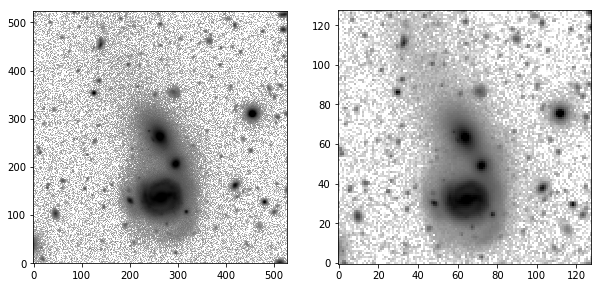

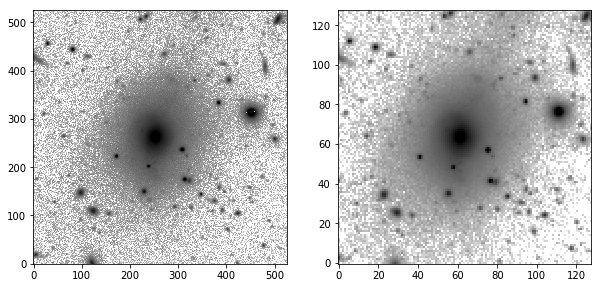

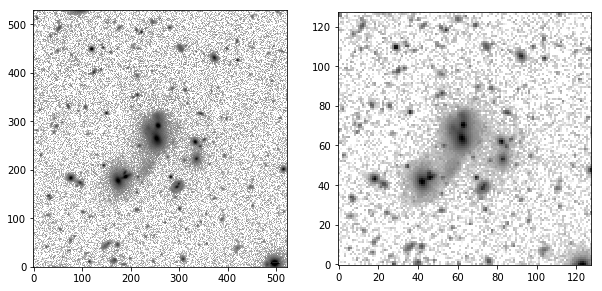

In [3]:
#!/usr/bin/env python

from astropy.io import fits
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from rebin import rebin
from scipy import interpolate

# catalogue name
catName = '../Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')[:3]
# directory in which all of the downloaded HSC images are stored
idir = '/home/bottrell/scratch/Subaru/HyperSuprime/Input/'
odir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Resized/'

arcsec_per_pixel = 0.168
oShape = (512,512) # crop shape
rShape = (128,128) # rebin shape
oRows,oCols = oShape[0],oShape[1]

objIDs = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)
# use r-band sizes to set scale
# sizes = catData[:,7].astype(float)/arcsec_per_pixel # pixels

# filterIDs = ['g','r','i','z','y']
filterIDs = ['i']

for objID,ra,dec in zip(objIDs,ras,decs):
    
    for filterID in filterIDs:
        
        # input filenames
        fileName = '{}{}_Cutout-525x525_{}.fits'.format(idir,objID,filterID)
        # output filenames
        outName = fileName.replace(idir,odir).replace('525x525','Resized')
        
        print(fileName)
        # check to see if input exists or output is already there
        # skip if either is true
        # if (not os.access(fileName,0)) or os.access(outName,0): continue
            
        iData = fits.getdata(fileName)
        iShape = iData.shape
        # difference in rows and columns from desired shape
        dRows,dCols = iShape[0]-oRows,iShape[1]-oCols
        hRows,hCols = int(dRows/2),int(dCols/2)
        
        if dRows%2==0: # take equal number of rows from bottom and top
            oData = iData[hRows:-hRows,:]
        else: # take 1 more pixel from the top always
            oData = iData[hRows+1:-hRows,:]
            
        if dCols%2==0: # take equal number of rows from left and right
            oData = oData[:,hCols:-hCols]
        else: # take 1 more pixel from the left always
            oData = oData[:,hCols:-(hCols+1)]
            
        oShape = oData.shape
        oHdr = fits.getheader(fileName,1)
        
        # use rebin tool if new shape is smaller than input
        if rShape[0]<oShape[0]:
            oData = rebin(oData,rShape)*float(rShape[0]*rShape[1]/oShape[0]/oShape[1])
        # use interp2d if new shape is smaller than input
        if rShape[0]>oShape[0]:
            x = np.linspace(0,1,oShape[0])
            y = np.linspace(0,1,oShape[1])
            f = interpolate.interp2d(x, y, oData, kind='linear')
            xn = np.linspace(0,1,rShape[0])
            yn = np.linspace(0,1,rShape[1])
            oData = f(xn,yn)

        oHdr['NAXIS1']=rShape[1]
        oHdr['NAXIS2']=rShape[0]
        
        fig,axarr = plt.subplots(1,2,figsize=(10,5))
        axarr[0].imshow(np.log10(iData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        axarr[1].imshow(np.log10(oData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
#         fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Interp_Demo.pdf',bbox_inches='tight')
#         fits.writeto(outName,data=oData,header=oHdr)
        
        

### Cutout sizes scaled by `r_det`

Here I check whether a certain scale factor applied to the sizes from the `HSC-TF_all_2019-07-16_size_estimates.txt` catalogue is appropriately big/small such that the streams/shells are still visible but the image is small enough so that it does not include more sources.

5.560652764763616
4.4470595681335565


/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in log10


5.560652764763616
5.228106229304237


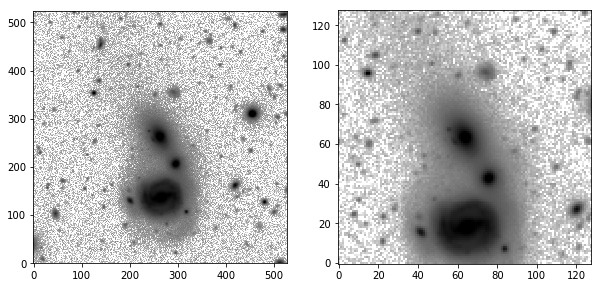

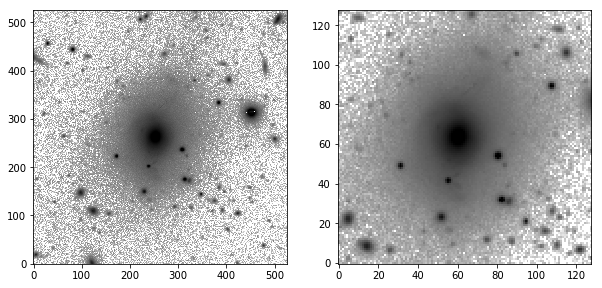

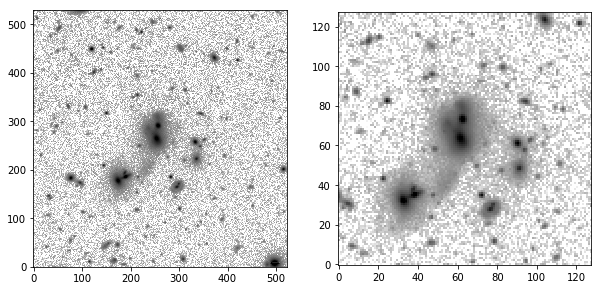

In [5]:
from astropy.io import fits
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from rebin import rebin
from scipy import interpolate

# catalogue name
catName = '../Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')[:3]
# directory in which all of the downloaded HSC images are stored
idir = '/home/bottrell/scratch/Subaru/HyperSuprime/Input/'
odir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/'

arcsec_per_pixel = 0.168
oShape = (512,512) # crop shape
rShape = (128,128) # rebin shape
oRows,oCols = oShape[0],oShape[1]

objIDs = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)
# use r-band sizes to set scale
sizes = catData[:,7].astype(float)/arcsec_per_pixel # pixels
#print(np.max(sizes))
# filterIDs = ['g','r','i','z','y']
filterIDs = ['i']

for objID,ra,dec,size in zip(objIDs,ras,decs,sizes):
    
    for filterID in filterIDs:
        
        # input filenames
        fileName = '{}{}_Cutout-525x525_{}.fits'.format(idir,objID,filterID)
        # output filenames
        outName = fileName.replace(idir,odir).replace('525x525','Resized')
        
        # check to see if input exists or output is already there
        # skip if either is true
        if (not os.access(fileName,0)) or os.access(outName,0): continue
            
        iData = fits.getdata(fileName)
        iShape = iData.shape
        
        print(size)
        testSize = int(np.ceil(size*80))
        if testSize > oShape[0] or testSize > oShape[1]:
            oRows,oCols = oShape[0],oShape[1]
        else:
            oRows = oCols = testSize
        oShape = (oRows,oCols)
        
        # difference in rows and columns from desired shape
        dRows,dCols = iShape[0]-oRows,iShape[1]-oCols
        hRows,hCols = int(dRows/2),int(dCols/2)
        
        if dRows%2==0: # take equal number of rows from bottom and top
            oData = iData[hRows:-hRows,:]
        else: # take 1 more pixel from the top always
            oData = iData[hRows+1:-hRows,:]
            
        if dCols%2==0: # take equal number of rows from left and right
            oData = oData[:,hCols:-hCols]
        else: # take 1 more pixel from the left always
            oData = oData[:,hCols:-(hCols+1)]
            
        oShape = oData.shape
        oHdr = fits.getheader(fileName,1)
        
        # use rebin tool if new shape is smaller than input
        if rShape[0]<oShape[0]:
            oData = rebin(oData,rShape)*float(rShape[0]*rShape[1]/oShape[0]/oShape[1])
        # use interp2d if new shape is smaller than input
        if rShape[0]>oShape[0]:
            x = np.linspace(0,1,oShape[0])
            y = np.linspace(0,1,oShape[1])
            f = interpolate.interp2d(x, y, oData, kind='linear')
            xn = np.linspace(0,1,rShape[0])
            yn = np.linspace(0,1,rShape[1])
            oData = f(xn,yn)

        oHdr['NAXIS1']=rShape[1]
        oHdr['NAXIS2']=rShape[0]
        
        fig,axarr = plt.subplots(1,2,figsize=(10,5))
        axarr[0].imshow(np.log10(iData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        axarr[1].imshow(np.log10(oData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        
        

### Cropping and resizing the images

First, the image is cropped so that it focuses on the main target. This cropping should be based on some scaling of the target galaxy's size -- but one should recall that there are tidal features in the images which extend beyond the target galaxy's main profile. Once the image is cropped, it is rebinned to a consistent size that is fixed for all images.

/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log10


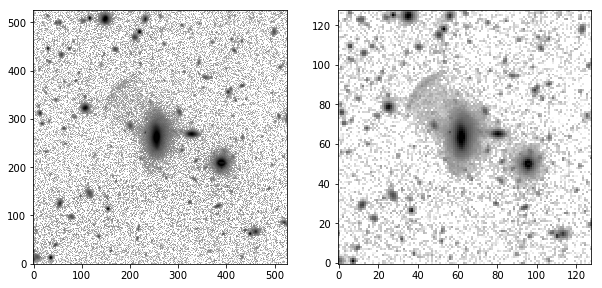

In [12]:
from astropy.io import fits
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from rebin import rebin
from scipy import interpolate

# directory in which all of the downloaded HSC images are stored
idir = '/home/bottrell/scratch/Subaru/HyperSuprime/Input/'
odir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/'

# filename placeholders
_fileList_ = sorted(list(glob.glob('{}*525x525_i.fits'.format(idir))))[:1]
_fileList_ = [fileName.replace('_i.fits','_{}.fits') for fileName in _fileList_]

# square shape to which the image is cropped
oShape = (512,512)
# shape to which the cropped image is rebinned (all final images should be this size)
rShape = (128,128)

oRows,oCols = oShape[0],oShape[1]

# filters in which to perform operations (if files exist)
# filterIDs = ['g','r','i','z','y']
filterIDs = ['i']

for _fileName_ in _fileList_:
    
    for filterID in filterIDs:
        
        # input filenames
        fileName = _fileName_.format(filterID)
        # output filenames
        outName = fileName.replace(idir,odir).replace('525x525','Resized')
        
        # check to see if input exists or output is already there
        # skip if either is true
        if (not os.access(fileName,0)) or os.access(outName,0): continue
            
        iData = fits.getdata(fileName)
        iShape = iData.shape
        # difference in rows and columns from desired shape
        dRows,dCols = iShape[0]-oRows,iShape[1]-oCols
        hRows,hCols = int(dRows/2),int(dCols/2)
        
        if dRows%2==0: # take equal number of rows from bottom and top
            oData = iData[hRows:-hRows,:]
        else: # take 1 more pixel from the top always
            oData = iData[hRows+1:-hRows,:]
            
        if dCols%2==0: # take equal number of rows from left and right
            oData = oData[:,hCols:-hCols]
        else: # take 1 more pixel from the left always
            oData = oData[:,hCols:-(hCols+1)]
            
        oShape = oData.shape
        oHdr = fits.getheader(fileName,1)
        
        # use rebin tool if new shape is smaller than input
        if rShape[0]<oShape[0]:
            oData = rebin(oData,rShape)*float(rShape[0]*rShape[1]/oShape[0]/oShape[1])
        # use interp2d if new shape is smaller than input
        if rShape[0]>oShape[0]:
            x = np.linspace(0,1,oShape[0])
            y = np.linspace(0,1,oShape[1])
            f = interpolate.interp2d(x, y, oData, kind='linear')
            xn = np.linspace(0,1,rShape[0])
            yn = np.linspace(0,1,rShape[1])
            oData = f(xn,yn)

        oHdr['NAXIS1']=rShape[1]
        oHdr['NAXIS2']=rShape[0]
        
        fig,axarr = plt.subplots(1,2,figsize=(10,5))
        axarr[0].imshow(np.log10(iData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        axarr[1].imshow(np.log10(oData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        #fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Interp_Demo.pdf',bbox_inches='tight')
        #fits.writeto(outName,data=oData,header=oHdr)
        


### Multiprocessing tests

Here I am comparing the speed of processing the cutouts using `multiprocessing` compared to an ordinary `for` loop on a Beluga node. This code was eventually used to rebin all of the cutouts from the catalogue.

In [3]:
#!/usr/bin/env python

from astropy.io import fits
import numpy as np
import os,sys,glob
from rebin import rebin
from scipy import interpolate
import multiprocessing,time

# enviornment properties
SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE'])

# catalogue name
catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')
# directory in which all of the downloaded HSC images are stored
idir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/'
odir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Resized/'

arcsec_per_pixel = 0.168
oShape = (512,512) # crop shape
rShape = (128,128) # rebin shape

objIDs = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)
# use r-band sizes to set scale
# sizes = catData[:,7].astype(float)/arcsec_per_pixel # pixels

# filterIDs = ['g','r','i','z','y']
filterIDs = ['i']
        
def Resize_Cutout(arg):
    fileName,outName,oShape,rShape = arg

    oRows,oCols = oShape[0],oShape[1]
    iData = fits.getdata(fileName)
    iShape = iData.shape
    # difference in rows and columns from desired shape
    dRows,dCols = iShape[0]-oRows,iShape[1]-oCols
    hRows,hCols = int(dRows/2),int(dCols/2)

    if dRows%2==0: # take equal number of rows from bottom and top
        oData = iData[hRows:-hRows,:]
    else: # take 1 more pixel from the top always
        oData = iData[hRows+1:-hRows,:]

    if dCols%2==0: # take equal number of rows from left and right
        oData = oData[:,hCols:-hCols]
    else: # take 1 more pixel from the left always
        oData = oData[:,hCols:-(hCols+1)]

    oShape = oData.shape
    oHdr = fits.getheader(fileName,1)
    # use rebin tool if new shape is smaller than input
    if rShape[0]<oShape[0]:
        oData = rebin(oData,rShape)*float(rShape[0]*rShape[1]/oShape[0]/oShape[1])
    # use interp2d if new shape is smaller than input
    if rShape[0]>oShape[0]:
        x = np.linspace(0,1,oShape[0])
        y = np.linspace(0,1,oShape[1])
        f = interpolate.interp2d(x, y, oData, kind='linear')
        xn = np.linspace(0,1,rShape[0])
        yn = np.linspace(0,1,rShape[1])
        oData = f(xn,yn)
    oHdr['NAXIS1']=rShape[1]
    oHdr['NAXIS2']=rShape[0]
    fits.writeto(outName,data=oData,header=oHdr)

# list of filenames, output names, crop shapes and final shapes
args = [ ('{}{}_Cutout-525x525_{}.fits'.format(idir,objID,filterID),'{}{}_Cutout-Resized_{}.fits'.format(odir,objID,filterID),oShape,rShape) for objID,ra,dec in zip(objIDs,ras,decs) for filterID in filterIDs ]

argList = []
for arg in args:
    if os.access(arg[0],0) and not os.access(arg[1],0):
        argList.append(arg)
argList = list(set(argList))

if __name__ == '__main__':
    pool = multiprocessing.Pool(SLURM_CPUS)
    pool.map_async(Resize_Cutout, argList)
    pool.close()
    pool.join()

### Compute `SExtractor` sizes for all galaxies in catalog

The `r_det` values seem to be often erroneous. I try to get around this by computing `SExtractor` sizes for each galaxy.

In [ ]:
#!/usr/bin/env python

# Compute SExtractor sizes and create new catalogue

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os,sys,datetime,time
from glob import glob
from astropy.io import fits
from astropy.wcs import WCS
import sep
now = datetime.datetime.now()
author = 'Connor Bottrell'

def Generate_Segmap(filename,galaxy_coordinates_wcs):
    '''
    Return a segmentation map where: (1) only the target galaxy is 
    included in the map and everything else is background; and (2)
    every object has a unique flag and the target is at the center
    of the colormap. Next returns are (3) the flagID of the 
    primary galaxy, (4) median background estimate (sky only),
    (5) rms estimate of background (sky pixels), (6) a catalog of
    all object properties.
    '''
    # Primary HDU for file
    hdulist = fits.open(filename)
    # obtain wcs info
    w = WCS(hdulist[1].header, hdulist)
    # image data
    image = hdulist[1].data.astype(float)
    # close Primary HDU
    hdulist.close()
    # filter kernel
    filter_kernel = np.loadtxt('/home/bottrell/utils/sdss-cfg/gauss_3.0_7x7.conv',skiprows=2)
    # use std of full image as detection threshold
    guess_rms = np.std(image)
    # mask all sources above std for background statistics
    mask = (image>guess_rms)
    # bkg object which includes sky() and rms() methods
    bkg = sep.Background(image, mask=mask, bw=32, bh=32, fw=3, fh=3)
    # run sep.extract() on image
    objCat,sexseg = sep.extract(image, thresh=1.0, err=bkg.rms(), mask=None, minarea=5,
                             filter_kernel=filter_kernel,filter_type='conv',deblend_nthresh=32,
                             deblend_cont=0.001, clean=True,clean_param=1.0, segmentation_map=True)
    # median background
    bkg_med = np.median(image[sexseg==0])
    # background noise
    bkg_rms = np.std(image[sexseg==0])
    # determine galaxy position in pixels (origin 0 for python indexing)
    galaxy_coordinates_pixels = tuple(w.wcs_world2pix([galaxy_coordinates_wcs],0).astype(int)[0][::-1])
    # identify flag for target galaxy in segmentation map
    pflag = sexseg[galaxy_coordinates_pixels]
    # galaxy segmentation map (only these pixels are used in the model)
    galseg = sexseg==pflag
    return galseg,sexseg,pflag,bkg_med,bkg_rms,objCat

catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')

# objIDs = catData[:,0].astype(int)
# ras = catData[:,2].astype(float)
# decs = catData[:,3].astype(float)

# Subaru HSC pixel scale
arcsec_per_pixel = 0.168

# priority ordering of filterIDs
filterIDs = ['g','r','i','z','y']

with open(catName,'r') as f:
    lines = f.readlines()
    
newCat = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-25.txt'

# if os.access(newCat,0):os.remove(newCat) #!!! Remove after testing
    
if not os.access(newCat,0):
    with open(newCat,'w') as f:
        f.write('#'*50+'\n')
        f.write('# File initialized: {}\n'.format(datetime.datetime.now()))
        f.write('# By: {}\n'.format(author))
        f.write('#'*50+'\n')
        header = lines[0].split('\n')[0].split(',')
        header = header + ['req_sex_{}'.format(filterID) for filterID in filterIDs]
        header[0] = 'objectID_Cat'
        for ii,entry in enumerate(header):
            f.write('# [{}] {}\n'.format(ii,entry))
        f.write('#'*50+'\n')
    objIDs_Done = np.array([])
else:
    objIDs_Done = np.loadtxt(newCat,delimiter=',',dtype='str')[:,0].astype(int)


imgDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/'

for line in lines[1:]:

    line = line.split('\n')[0]
    objID,z,ra,dec=line.split(',')[:4]
    objID = int(objID)
    if objID in objIDs_Done: continue
    z = float(z)
    ra = float(ra)
    dec = float(dec)
    
    req_arcsec = np.zeros(len(filterIDs))
    
    for i,filterID in enumerate(filterIDs):
        # filename
        fileName = '{}{}_Cutout-525x525_{}.fits'.format(imgDir,objID,filterID)
        # continue if image does not exist
        if not os.access(fileName,0):
            req_arcsec[i] = -1
            continue
        galaxy_coordinates_wcs = (ra,dec)

        try:
            galseg,sexseg,pflag,bkg_med,bkg_rms,objCat = Generate_Segmap(fileName,galaxy_coordinates_wcs)
            area_pixels = objCat[pflag-1][1]
            req_pixel = np.sqrt(float(area_pixels)/np.pi)
            req_arcsec[i] = req_pixel*arcsec_per_pixel
        except:
            req_arcsec[i] = -999

    newLine = ','.join(['%0.3f'%req_arcsec[i] for i in range(len(filterIDs))])
    print(fileName,newLine)
#     with open(newCat,'a') as f:
#         f.write('{},{}\n'.format(line,newLine))

/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237660024493572454_Cutout-525x525_y.fits 0.683,7.996,3.646,3.142,2.840
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237679338959667319_Cutout-525x525_y.fits 8.949,11.160,10.043,9.151,6.992
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237663480335958649_Cutout-525x525_y.fits 2.955,4.236,5.306,-999.000,3.926
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237678881547026839_Cutout-525x525_y.fits 10.377,12.500,10.563,8.638,7.853
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237678879959745127_Cutout-525x525_y.fits 2.223,3.232,3.446,3.067,2.651
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237679255205904514_Cutout-525x525_y.fits 5.792,7.052,8.003,6.711,6.149


In [1]:
import numpy as np

catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-25.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')

objIDs_new = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)
r_sex = catData[:,-1].astype(float)



catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')

objIDs_old = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)
r_sex = catData[:,-1].astype(float)

for i,objID in enumerate(objIDs_new):
    if objID == objIDs_old[i]:
        continue
    print(i)



In [4]:
import numpy as np

catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-25.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')

objIDs = catData[:,0].astype(int)

r_sex = catData[:,14].astype(float)

print(float(len(r_sex[r_sex<0]))/len(r_sex)*100)

0.32058837395690915
